# El gradiente de deformación $\boldsymbol{F}$

El gradiente de deformación $\boldsymbol{F}$ es un tensor que se emplea para separar las rotaciones asociadas al cuerpo rígido de las deformaciones.

En lo que sigue emplearemos la siguiente convención
* $\boldsymbol{X}$ representa las coordenadas de una partícula en el tiempo referencial $t_0$ (coordenadas materiales)
* $\boldsymbol{x}$ representa las coordenadas de una partícula en el tiempo $t$ (coordenadas espaciales)
* $\boldsymbol{x} = \boldsymbol{\chi}(\boldsymbol{X},t)$ representa la posición de la partícula, en un tiempo $t$, que en el tiempo referencial $t_0$ se encontraba en la posición $\boldsymbol{X}$.


In [1]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np

A continuación se definirán ciertas funciones que utilizaremos en las explicaciones:

La función `estimar_chi()` sirve para estimar, mediante una regresión lineal, la función $\boldsymbol{\chi}$ a partir de las coordenadas iniciales $\boldsymbol{X}$ y finales $\boldsymbol{x}$ de un rectángulo:

In [2]:
def estimar_chi(xx, XX):
    # Parámetros de entrada:
    #     xx -> np.array() de 4x2 con las coordenadas espaciales
    #     XX -> np.array() de 4x2 con las coordenadas materiales
    # Parámetros de salida:
    #     chi -> mapeo entre XX y xx
    
    X, Y = XX[:,0], XX[:,1]   # coordenadas materiales
    x, y = xx[:,0], xx[:,1]   # coordenadas espaciales

    # se definen las variables de la regresión
    ax0, ax1, ax2, ax3 = sp.symbols('ax0:4')
    ay0, ay1, ay2, ay3 = sp.symbols('ay0:4')
    
    # se plantean los sistemas de ecuaciones
    ecs_x = 4*[None]
    ecs_y = 4*[None]
    for i in range(4):
        ecs_x[i] = sp.Eq(x[i], ax0 + ax1*X[i] + ax2*Y[i] + ax3*X[i]*Y[i])
        ecs_y[i] = sp.Eq(y[i], ay0 + ay1*X[i] + ay2*Y[i] + ay3*X[i]*Y[i])

    # se resuelven los sistemas de ecuaciones
    solx = sp.solve(ecs_x, [ax0, ax1, ax2, ax3])
    soly = sp.solve(ecs_y, [ay0, ay1, ay2, ay3])
       
    # se retorna la función chi()
    X, Y = sp.symbols('X Y')    
    return sp.Matrix([ solx[ax0] + solx[ax1]*X + solx[ax2]*Y + solx[ax3]*X*Y,
                       soly[ay0] + soly[ay1]*X + soly[ay2]*Y + soly[ay3]*X*Y ])

La función `evaluar_chi()`, a partir de la función de movimiento $\boldsymbol{\chi}$, dada por `chi`, calcula las posiciones espaciales de las partículas que originalmente estaban en las posiciones materiales `npX`, `npY`

In [3]:
def evaluar_chi(chi, npX, npY):
    # Parámetros de entrada:
    #     chi -> mapeo entre XX y xx    
    #     npX -> np.array() de tamaño n con las coordenadas materiales X
    #     npY -> np.array() de tamaño n con las coordenadas materiales Y
    # Parámetros de salida:
    #     x -> np.array() de tamaño n con las coordenadas espaciales x
    #     y -> np.array() de tamaño n con las coordenadas espaciales y
    
    # se crea la función a evaluar con numpy
    X, Y = sp.symbols('X Y')
    f = sp.lambdify((X,Y), chi, "numpy")
    
    # se evalúa la función chi y 
    # se elimina la dimensión adicional creada por sp.lambdify
    xx = np.squeeze(f(npX,npY))
        
    # se retorna la evaluación de la función chi()
    x, y = xx[0], xx[1]    
    return x, y

La función `dibujar_chi()`, dibuja la posición material (inicial) y espacial (final) del polígono cuyas aristas están indicadas en el array `XX` a partir de la función de movimiento $\boldsymbol{\chi}$, dada por `chi`. Esta función recibe adicionalemente un tercer parámetro `ejes` el cual contiene las posiciones `[xmin, xmax, ymin, ymax]` de la figura.

In [4]:
def dibujar_chi(chi, XX, ejes, contorno=False, vec_prop=True): 
    # Parámetros de entrada:
    #     chi  -> mapeo entre XX y xx    
    #     XX   -> np.array() de tamaño nx2 con los vértices del polígono en coordenadas materiales
    #     ejes -> [xmin, xmax, ymin, ymax]
    X, Y = XX[:,0], XX[:,1]
    x, y = evaluar_chi(chi, X, Y)
    
    # Se dibuja la posición material (inicial) y la espacial (actual)
    fig, ax = plt.subplots(figsize =(16, 8))
    ax.plot(np.r_[X, X[0]], np.r_[Y, Y[0]], label='material')    
    ax.plot(np.r_[x, x[0]], np.r_[y, y[0]], label='espacial')
    ax.set_aspect('equal') 
    ax.legend()
    
    # se dibuja el campo vectorial de desplazamientos
    xmin, xmax, ymin, ymax = ejes
    XX = np.linspace(xmin, xmax, 20)
    YY = np.linspace(ymin, ymax, 20)
    X, Y = np.meshgrid(XX, YY)
    x, y = evaluar_chi(chi, X, Y)
    ax.quiver(X, Y, x-X, y-Y) # angles='xy', scale_units='xy', scale=1)
    
    if contorno:
        # Se calcula el gradiente de deformación F de la función chi
        X_, Y_ = sp.symbols('X Y')
        F = np.array(chi.jacobian([X_,Y_])).astype(np.float64)    

        b = F @ F.T # left Cauchy-Green tensor
        invb = np.linalg.inv(b)
        xT_invb_X = np.zeros_like(X)        
        m, n = X.shape
        for i in range(m):
            for j in range(n):
                mix = np.array([X[i,j], Y[i,j]])
                xT_invb_X[i,j] = mix.T@invb@mix
        ax.contour(X,Y,xT_invb_X, 30)

        if vec_prop:
            valp, vecp = np.linalg.eig(invb)
            ax.quiver(0, 0, vecp[0,0], vecp[1,0], angles='xy', scale_units='xy', scale=valp[0]) 
            ax.quiver(0, 0, vecp[0,1], vecp[1,1], angles='xy', scale_units='xy', scale=valp[1])         
    
    plt.show()

## Creación de la función $\boldsymbol{\chi}$ a partir de las posiciones inicial y final

In [5]:
XX = np.array([(-1,-1), (1,-1), (1,1),  (-1,1)])   # posición inicial (referencial)
xx = np.array([( 1, 2), (2, 5), (2, 6), ( 1,4)])   # posición actual  (espacial)

Se estima la función $\boldsymbol{x} = \boldsymbol{\chi}(\boldsymbol{X})$:

In [6]:
chi = estimar_chi(xx, XX)
chi

Matrix([
[                    X/2 + 3/2],
[-X*Y/4 + 5*X/4 + 3*Y/4 + 17/4]])

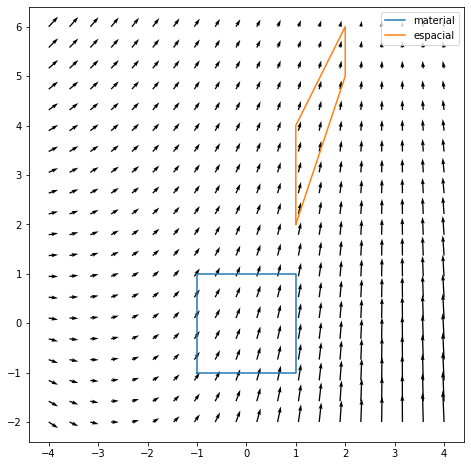

In [7]:
dibujar_chi(chi, XX, [-4, 4, -2, 6])

## Cálculo del gradiente de deformación $\boldsymbol{F}$

Se calcula el gradiente de deformación $\boldsymbol{F}$ como el gradiente del campo vectorial de desplazamientos $\boldsymbol{\chi}$:

In [8]:
X, Y = sp.symbols('X Y')
F1 = chi.jacobian([X,Y])
F1

Matrix([
[      1/2,         0],
[5/4 - Y/4, 3/4 - X/4]])

Se calcula el vector de desplazamientos $\boldsymbol{u} = \boldsymbol{x} - \boldsymbol{X}$

In [9]:
u = chi - sp.Matrix([X,Y])
u

Matrix([
[                  3/2 - X/2],
[-X*Y/4 + 5*X/4 - Y/4 + 17/4]])

Se calcula el gradiente de deformación $\boldsymbol{F}$ como $\boldsymbol{F} = \boldsymbol{I} + \frac{\partial\boldsymbol{u}}{\partial\boldsymbol{X}}$:

In [10]:
I = sp.eye(2)
F2 = I + u.jacobian([X,Y])
F2

Matrix([
[      1/2,         0],
[5/4 - Y/4, 3/4 - X/4]])

## Desplazamiento rígido

Observe que en el caso de desplazamiento rígido $\boldsymbol{F} = \boldsymbol{I}$, lo que indica que no hay deformaciones.

In [11]:
chi = sp.Matrix([[X + 5], 
                 [Y + 2]])
F = chi.jacobian([X,Y])
F

Matrix([
[1, 0],
[0, 1]])

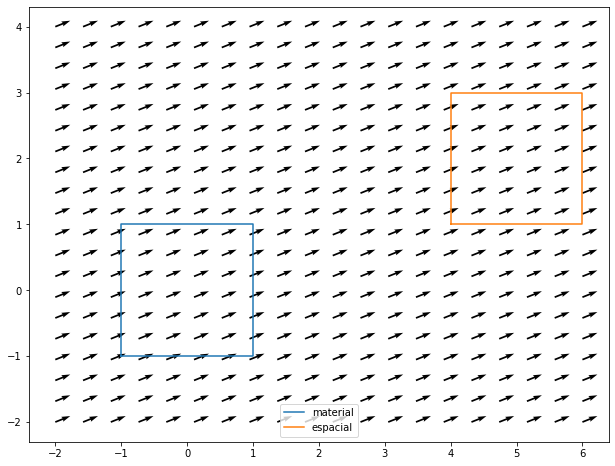

In [12]:
dibujar_chi(chi, XX, [-2, 6, -2, 4])

## Rotación rígida

Observe que en el caso de rotación rígida $F_{21} = -F_{12}$ y $F_{11} = F_{22}$; adicionalmente $\boldsymbol{F} \neq \boldsymbol{I}$ a pesar de que no hay deformaciones.

In [13]:
t = np.deg2rad(15)
chi = sp.Matrix([[ X*sp.cos(t) - Y*sp.sin(t) ], 
                 [ X*sp.sin(t) + Y*sp.cos(t) ]]) 
F = chi.jacobian([X,Y])
F

Matrix([
[0.965925826289068, -0.258819045102521],
[0.258819045102521,  0.965925826289068]])

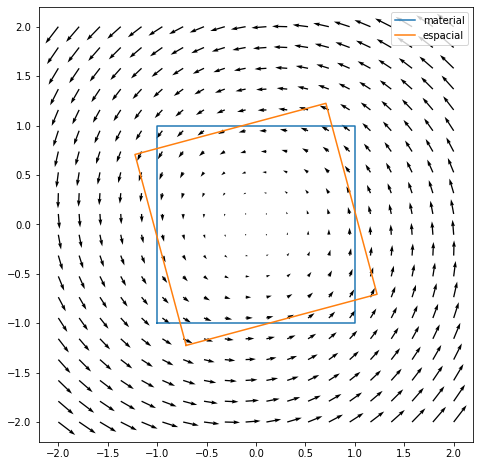

In [14]:
dibujar_chi(chi, XX, [-2, 2, -2, 2])

## Estiramiento en ambas direcciones

En este caso la forma final será del doble en la dirección $x$ y del triple en la dirección $y$; adicionalmente, los términos fuera de la diagonal son nulos.

Aquí las curvas de contorno se emplearán para entender el tensor izquierdo de Cauchy-Green $\boldsymbol{b}$. 

In [15]:
chi = sp.Matrix([[2*X + 0*Y], 
                 [0*X + 3*Y]])
F = chi.jacobian([X,Y])
F

Matrix([
[2, 0],
[0, 3]])

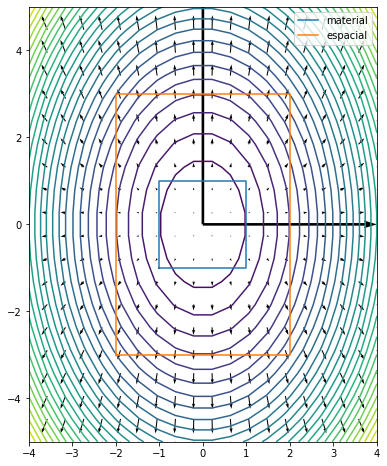

In [16]:
dibujar_chi(chi, XX, [-4, 4, -5, 5], contorno=True)

## Deformación angular (con rotación)

En este caso el término $F_{21}$ simboliza la deformación angular; adicionalemente, el sólido tiende a rotar en la dirección contraria a las manecillas del reloj.

In [17]:
chi = sp.Matrix([[1.0*X + 0.0*Y], 
                 [0.5*X + 1.0*Y]])
F = chi.jacobian([X,Y])
F

Matrix([
[1.0,   0],
[0.5, 1.0]])

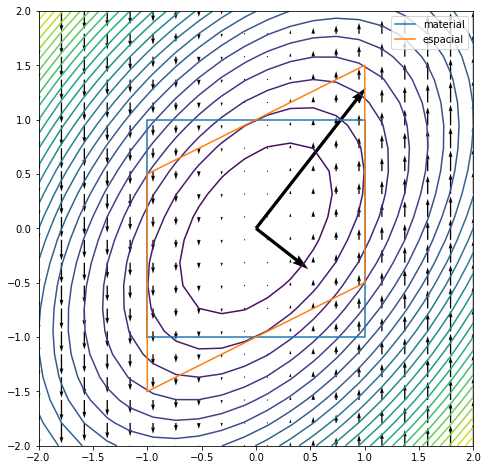

In [18]:
dibujar_chi(chi, XX, [-2, 2, -2, 2], contorno=True)

## Deformación angular pura

El hecho de que $F_{12} \neq 0$ y $F_{21} \neq 0$ indica que la deformación angular está presente. El hecho de que $F_{11} = F_{22}$ indica que no hay rotación.

In [19]:
chi = sp.Matrix([[1.0*X + 0.5*Y], 
                 [0.5*X + 1.0*Y]])
F = chi.jacobian([X,Y])
F

Matrix([
[1.0, 0.5],
[0.5, 1.0]])

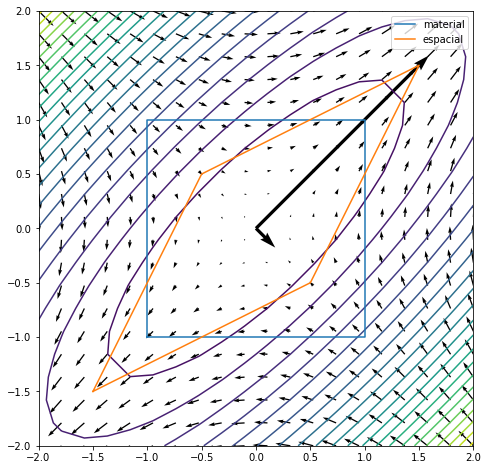

In [20]:
dibujar_chi(chi, XX, [-2, 2, -2, 2], contorno=True)

## Deformaciones generales

El sólido tiene estiramientos, deformaciones angulares y rotación presente:

In [21]:
chi = sp.Matrix([[1.0*X - 0.675*Y], 
                 [0.3*X + 0.650*Y]])
F = chi.jacobian([X,Y])
F

Matrix([
[1.0, -0.675],
[0.3,   0.65]])

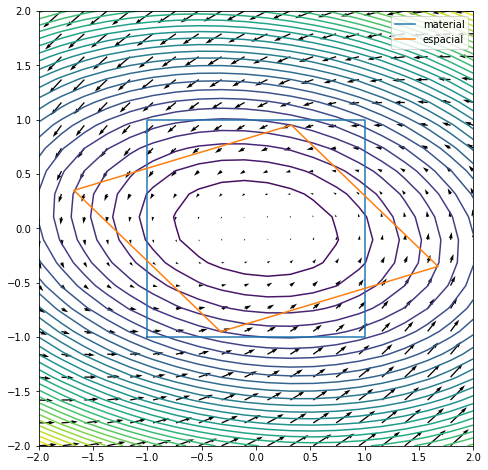

In [22]:
dibujar_chi(chi, XX, [-2, 2, -2, 2], contorno=True, vec_prop=False)

## Descomposición polar

La descomposición polar se utiliza para ...

In [23]:
from scipy.linalg import polar

npF = np.array(F).astype(np.float64)
R1, U = polar(npF, 'right')  # F = R*U
R2, v = polar(npF, 'left')   # F = v*R

In [24]:
chiU = sp.Matrix(U) *sp.Matrix([X,Y])
chiR = sp.Matrix(R1)*sp.Matrix([X,Y])
chiv = sp.Matrix(v) *sp.Matrix([X,Y])

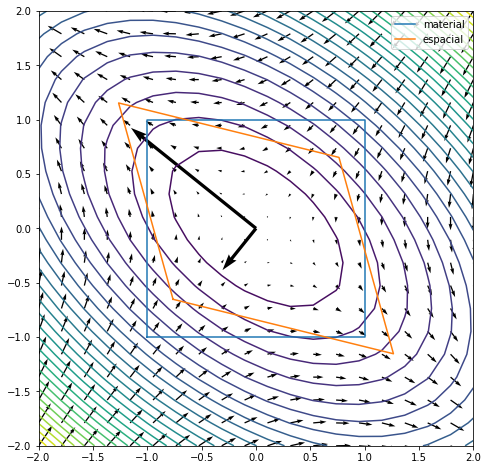

array([[ 1.01354532, -0.25045135],
       [-0.25045135,  0.90299453]])

In [25]:
dibujar_chi(chiU, XX, [-2, 2, -2, 2], contorno=True)
U

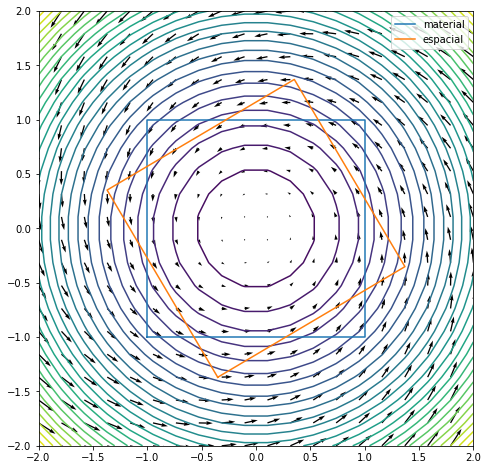

array([[ 0.86092653, -0.50872931],
       [ 0.50872931,  0.86092653]])

In [26]:
dibujar_chi(chiR, XX, [-2, 2, -2, 2], contorno=True, vec_prop=False)
R1

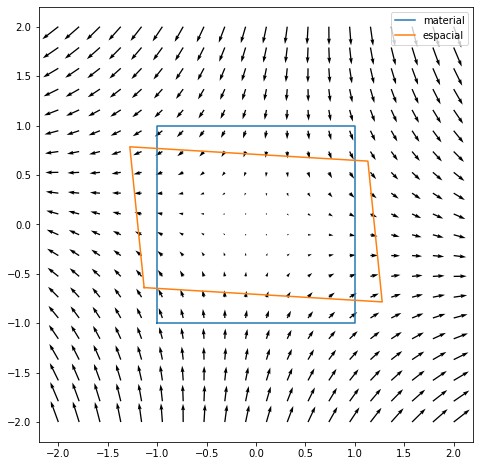

array([[ 1.20431881, -0.07239609],
       [-0.07239609,  0.71222104]])

In [27]:
dibujar_chi(chiv, XX, [-2, 2, -2, 2])
v